# Preparing Data & Importing Libraries

In this section we import the necessary python libraries and load out data sets.

+ The gdp per country dataset (the objective metric for economy)

+ The unemployment dataset

+ The global peace index dataset (the objective metric for safety)

+ The infant mortality dataset (the objective metric for health)

+ The World Happiness Report 2018 (happiness scores for domestic and foreign-born population)


In [3]:
from scipy.stats import spearmanr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df_unemp = pd.read_csv('Data/unemployment_CLEANED.csv')
df_gdp = pd.read_csv('Data/gdp per country_CLEANED.csv')
df_gpi = pd.read_csv('Data/Global Peace Index.csv')
df_mortal = pd.read_csv('Data/infant mortality_CLEANED.csv')
df_happy = pd.read_csv('Data/WHR18 happiness.csv')

At this point the non-happiness metrics except the Global Peace Index are cleaned to provide the average from the years 2015-2017, to proceed we need to clean the Global Peace Index data file in a similar manner and then merge all the data files

In [4]:
# Reshape GPI DataFrame from wide to long format
df_gpi_long = pd.melt(df_gpi, id_vars=['Country', 'iso3c'], value_vars=df_gpi.columns[2:], var_name='Year', value_name='GPI_Score')

# Convert and filter
df_gpi_long['Year'] = pd.to_numeric(df_gpi_long['Year'], errors='coerce')
df_gpi_long['GPI_Score'] = pd.to_numeric(df_gpi_long['GPI_Score'], errors='coerce')
df_gpi_filtered = df_gpi_long[df_gpi_long['Year'].between(2015, 2017)]

# Calculate the 3-Year Average
df_gpi_avg = df_gpi_filtered.groupby('Country')['GPI_Score'].mean().reset_index()

# Merge DataFrames
df_merge = pd.merge(df_happy, df_unemp, on='Country', how='left')
df_merge = pd.merge(df_merge, df_gdp, on='Country', how='left')
df_merge = pd.merge(df_merge, df_gpi_avg, on='Country', how='left')
df_merge = pd.merge(df_merge, df_mortal, on='Country', how='left')



# Dataset Overview

Now we initiate the Exploratory Data Analysis by providing a first look at the merged dataset. Our goal here is to confirm the data structure and check for missing values and plausible data ranges.



In [5]:
# Display the first few rows 
print(df_merge.head())

# Display column names and data types, and check missing values
df_merge.info()

# Display summary statistics for numerical columns
df_merge.describe()

       Country  Domestic Happiness wp16  Foreign Happiness wp16  \
0  Afghanistan                     3.85                    4.07   
1      Albania                     5.03                    5.29   
2      Algeria                     5.53                    5.84   
3       Angola                     4.41                    5.31   
4    Argentina                     6.44                    5.84   

   Foreign Born's avg source-country happiness wp16  Unemployment_Rate  \
0                                              5.41             11.184   
1                                               NaN             15.409   
2                                               NaN             11.136   
3                                               NaN                NaN   
4                                              5.85              8.347   

   GDP_per_Capita  GPI_Score  Infant_Mortality_Rate  
0      537.707239   3.326000              62.300000  
1     4254.716679   1.796333               7

,Domestic Happiness wp16,Foreign Happiness wp16,Foreign Born's avg source-country happiness wp16,Unemployment_Rate,GDP_per_Capita,GPI_Score,Infant_Mortality_Rate
count,163.000000,162.000000,118.000000,114.000000,139.000000,145.000000,139.000000
mean,5.402393,5.394877,5.309576,7.597832,14515.080062,1.990644,23.055875
std,1.098076,1.036560,0.670022,5.816109,19967.652402,0.463467,23.677744
min,3.350000,3.000000,3.990000,0.081000,250.982503,1.142333,1.933333
25%,4.475000,4.602500,4.687500,4.018083,1715.080225,1.695333,5.466667
50%,5.290000,5.300000,5.410000,5.892667,5896.652962,1.940333,13.866667
75%,6.255000,6.232500,5.810000,9.233667,18045.088199,2.182333,36.666667
max,7.710000,7.660000,6.970000,30.225000,107518.173310,3.334667,161.833333


### Overview Observations:

+ there are missing values in Unemployment Rate due to the usage of left merge to standardize the metrics only for countries included in the WHR18 report, this is abit lower than expected but it can be worked with.

+ the mean happiness for foreign-born and domestic-born is roughly equivalent (5.39 vs 5.4)

+ the infant_mortality_rate is skewed to the right (mean is significantly higher than the median)

+ the gdp_per_capita is extremely skewed to the right (mean is extremely higher than the median)


# Correlation Analysis

The previous steps confirmed the quality of the data and the distributions of our variables. This section will explore the relationships between those variables.

We will use Pearson Correlation Matrix to calculate the linear assosciation between those variables and domestic and foreign-born happiness. This will reveal how changes in economic factors (GDP and unemployment) and well-being factors (GPI and Infant Mortality) affect domestic and foreign-born happiness.

A Pearson Correlation Coefficient of 1 and -1 indicates a strong relationship, while values near 0 indicate a weak relationship.

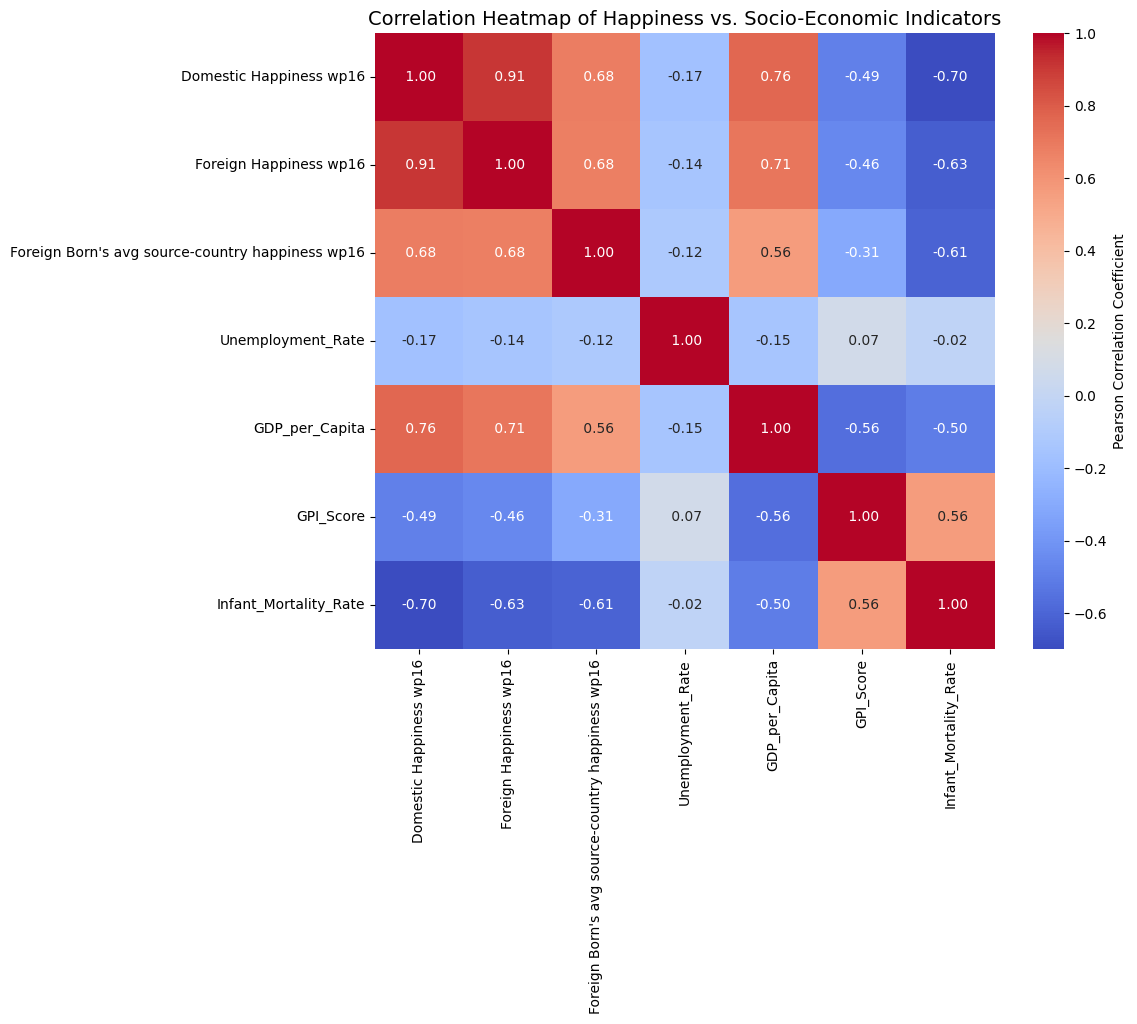

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_merge.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=" .2f", cbar_kws={'label': 'Pearson Correlation Coefficient'})
plt.title('Correlation Heatmap of Happiness vs. Socio-Economic Indicators', fontsize=14)
plt.show()

### Observations From the Heatmap

+ GDP per Capita shows the strongest positive relationship with both domestic and foreign happiness.
+ Infant Mortality Rate shows the strongest negative relationship with happiness.
+ Unemployment Rate has a surprisingly weak negative relationship with happiness.

# Visualization

## Country Metrics vs Domestic & Foreign-born happiness (Scatterplot):

This section will visualize the relationship between each country metric and Domestic & Foreign-born happiness to assess the degree of influence that each metric has and check for linearity and dimishing returns.

### Observations:

+ Almost in every plot the red and blue dots are situated tightly together indicating that country metrics are affecting Domestic & Foreign-born happiness similarly

+ Infant Mortality Rates and GDP Per Capita metrics are not entirely linear, they exhibit nonlinear behaviour. At low GDP Per Capita, happiness increases significantly faster than at high GDP Per Capita. At low Infant Mortality Rates, happiness decreases significantly faster than at high Infant Mortality Rates.

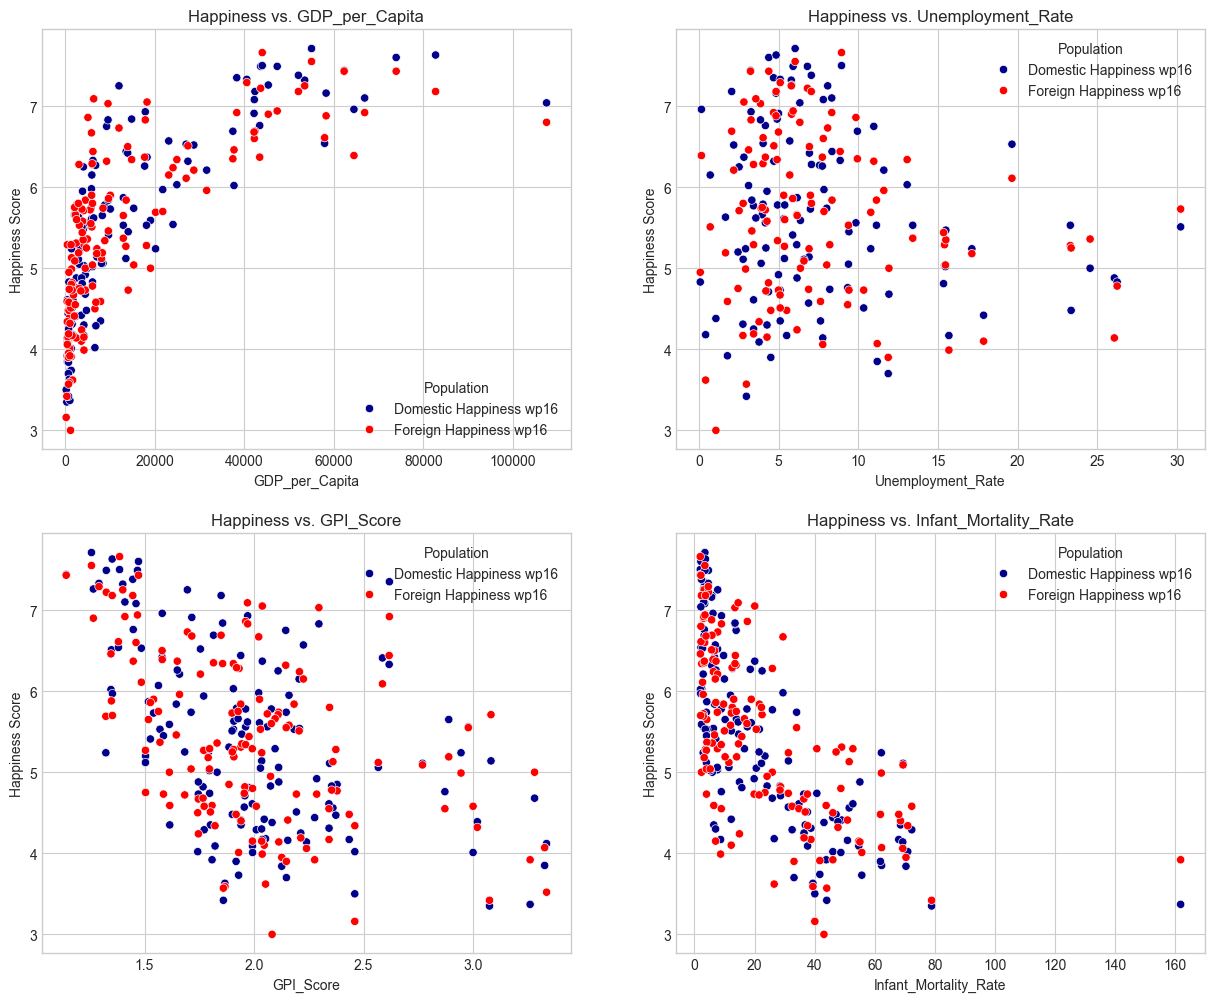

In [7]:

# Prepare data for comparative plotting (domestic vs. foreign happiness)
df_plot = df_merge.melt(
    id_vars = ['Country', 'GDP_per_Capita', 'Unemployment_Rate', 'GPI_Score', 'Infant_Mortality_Rate'],
    value_vars=['Domestic Happiness wp16', 'Foreign Happiness wp16'],
    var_name='Population_Type',
    value_name='Happiness_Score'
)

# Define the predictors to plot
predictors_to_plot = ['GDP_per_Capita', 'Unemployment_Rate', 'GPI_Score', 'Infant_Mortality_Rate']


plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, predictor in enumerate(predictors_to_plot):
    sns.scatterplot(
        data=df_plot,
        x=predictor,
        y='Happiness_Score',
        hue='Population_Type',  
        ax=axes[i],
        palette={'Domestic Happiness wp16': 'darkblue', 'Foreign Happiness wp16': 'red'}
    )
    
    
    axes[i].set_title(f'Happiness vs. {(predictor)}', fontsize=12)
    axes[i].set_xlabel((predictor))
    axes[i].set_ylabel('Happiness Score')
    axes[i].legend(title='Population')

plt.show()

# Hypothesis Testing

In this section we will evaluate whether there is a correlation between country metrics and happiness in the domestic-born population and the foreign-born population

### Hypothesis 1

**Null Hypothesis (H₀):** There is no statistically significant correlation between GDP Per Capita and **Domestic-born** happiness.

**Alternative Hypothesis (H₁):** There is a statistically significant correlation between GDP Per Capita and **Domestic-born** happiness.

### Hypothesis 2

**Null Hypothesis (H₀):** There is no statistically significant correlation between GDP Per Capita and **Foreign-born** happiness.

**Alternative Hypothesis (H₁):** There is a statistically significant correlation between GDP Per Capita and **Foreign-born** happiness.

In [8]:
# Extract GDP and Happiness data for Domestic and Foreign populations
# Domestic Data: Filter for Domestic rows and select the GDP column
gdp_domestic = df_plot[
    df_plot['Population_Type'] == 'Domestic Happiness wp16']['GDP_per_Capita']
happiness_domestic = df_plot[
    df_plot['Population_Type'] == 'Domestic Happiness wp16']['Happiness_Score']

# Foreign Data: Filter for Foreign rows and select the GDP column
gdp_foreign = df_plot[
    df_plot['Population_Type'] == 'Foreign Happiness wp16']['GDP_per_Capita']
happiness_foreign = df_plot[
    df_plot['Population_Type'] == 'Foreign Happiness wp16']['Happiness_Score']

# Other country metrics data
unemp_domestic = df_plot[
    df_plot['Population_Type'] == 'Domestic Happiness wp16']['Unemployment_Rate']
unemp_foreign = df_plot[
    df_plot['Population_Type'] == 'Foreign Happiness wp16']['Unemployment_Rate']

gpi_domestic = df_plot[
    df_plot['Population_Type'] == 'Domestic Happiness wp16']['GPI_Score']
gpi_foreign = df_plot[
    df_plot['Population_Type'] == 'Foreign Happiness wp16']['GPI_Score']

infant_domestic = df_plot[
    df_plot['Population_Type'] == 'Domestic Happiness wp16']['Infant_Mortality_Rate']
infant_foreign = df_plot[
    df_plot['Population_Type'] == 'Foreign Happiness wp16']['Infant_Mortality_Rate']


# Test Hypothesis 1 (Domestic GDP vs. Happiness)
rho_domestic, p_domestic = spearmanr(gdp_domestic, happiness_domestic, nan_policy='omit')

print("Hypothesis 1: Domestic Population")
print(f"Spearman's Rho (ρ): {rho_domestic:.2f}")
print(f"P-value: {p_domestic:.2e}")

# Test Hypothesis 2 (Foreign GDP vs. Happiness)
rho_foreign, p_foreign = spearmanr(gdp_foreign, happiness_foreign, nan_policy='omit')

print("\nHypothesis 2: Foreign Population")
print(f"Spearman's Rho (ρ): {rho_foreign:.2f}")
print(f"P-value: {p_foreign:.2e}")


# Test Hypothesis 3 (Domestic Unemployment vs. Happiness)
rho_domestic, p_domestic = spearmanr(unemp_domestic, happiness_domestic, nan_policy='omit')

print("\nHypothesis 3: Domestic Population")
print(f"Spearman's Rho (ρ): {rho_domestic:.2f}")
print(f"P-value: {p_domestic:.2e}")

# Test Hypothesis 4 (Foreign Unemployment vs. Happiness)
rho_foreign, p_foreign = spearmanr(unemp_foreign, happiness_foreign, nan_policy='omit')
print("\nHypothesis 4: Foreign Population")
print(f"Spearman's Rho (ρ): {rho_foreign:.2f}")
print(f"P-value: {p_foreign:.2e}")

# Test Hypothesis 5 (Domestic GPI vs. Happiness)
rho_domestic, p_domestic = spearmanr(gpi_domestic, happiness_domestic, nan_policy='omit')
print("\nHypothesis 5: Domestic Population")
print(f"Spearman's Rho (ρ): {rho_domestic:.2f}")
print(f"P-value: {p_domestic:.2e}")

# Test Hypothesis 6 (Foreign GPI vs. Happiness)
rho_foreign, p_foreign = spearmanr(gpi_foreign, happiness_foreign, nan_policy='omit')
print("\nHypothesis 6: Foreign Population") 
print(f"Spearman's Rho (ρ): {rho_foreign:.2f}")
print(f"P-value: {p_foreign:.2e}")

# Test Hypothesis 7 (Domestic Infant Mortality vs. Happiness)
rho_domestic, p_domestic = spearmanr(infant_domestic, happiness_domestic, nan_policy='omit')
print("\nHypothesis 7: Domestic Population")
print(f"Spearman's Rho (ρ): {rho_domestic:.2f}")
print(f"P-value: {p_domestic:.2e}")

# Test Hypothesis 8 (Foreign Infant Mortality vs. Happiness)
rho_foreign, p_foreign = spearmanr(infant_foreign, happiness_foreign, nan_policy='omit')
print("\nHypothesis 8: Foreign Population")
print(f"Spearman's Rho (ρ): {rho_foreign:.2f}")
print(f"P-value: {p_foreign:.2e}")


Hypothesis 1: Domestic Population
Spearman's Rho (ρ): 0.87
P-value: 8.59e-44

Hypothesis 2: Foreign Population
Spearman's Rho (ρ): 0.82
P-value: 5.32e-35

Hypothesis 3: Domestic Population
Spearman's Rho (ρ): -0.10
P-value: 2.99e-01

Hypothesis 4: Foreign Population
Spearman's Rho (ρ): -0.08
P-value: 3.81e-01

Hypothesis 5: Domestic Population
Spearman's Rho (ρ): -0.49
P-value: 3.77e-10

Hypothesis 6: Foreign Population
Spearman's Rho (ρ): -0.46
P-value: 8.75e-09

Hypothesis 7: Domestic Population
Spearman's Rho (ρ): -0.77
P-value: 1.65e-28

Hypothesis 8: Foreign Population
Spearman's Rho (ρ): -0.70
P-value: 1.26e-21


### Result Interpretation

Since the p-values are extremely low (p < 0.05) for both domestic and foreign populations, we reject both hypothesis. 

+ There is a statistically significant **positive** correlation between GDP Per Capita and **Domestic-born** happiness

+ There is a statistically significant **positive** correlation between GDP Per Capita and **Foreign-born** happiness

+ There is no statistically significant correlation between Unemployment and **Domestic-born** happiness

+ There is no statistically significant correlation between Unemployment and **Foreign-born** happiness

+ There is a statistically significant **negative** correlation between GPI and **Domestic-born** happiness

+ There is a statistically significant **negative** correlation between GPI and **Foreign-born** happiness

+ There is a statistically significant **negative** correlation between Infant Mortality and **Domestic-born** happiness

+ There is a statistically significant **negative** correlation between Infant Mortality and **Domestic-born** happiness
